# Generating music clusters from Spotify

In [131]:
# data wrangling
import pandas as pd
import numpy as np
import itertools
import random
import re

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from IPython.display import JSON


#API wrapper 
import spotify_keys # To use the code you need to import a .py file with your Spotify credentials (here stored in cid and csecret)
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA



# 1. Importing audio data

Choose from two existing data sets (1,000 or 5,000 tracks) or paste your own playlist (only the first 100 tracks)

In [132]:
# Example playlist: https://open.spotify.com/playlist/4Q0UT3K9L90mVI6rHdUxEE?si=662daba40c524808
songs_full_df = pd.DataFrame(get_music_source())
songs_df = songs_full_df.drop(['artist','name','duration_ms','time_signature','id','type','html'], axis=1)
#songs_full_df
#songs_df

Please choose your music source: 1: 1,000 songs, 2: 5,000 songs, 3: own playlist 1


In [133]:
def get_music_source():
    while True:
        try:
            source = int(input("Please choose your music source: 1: 1,000 songs, 2: 5,000 songs, 3: own playlist"))

            if source == 1:
                location1 = "https://raw.githubusercontent.com/jarisdata/Data_Science_Bootcamp/main/Project_4/data/df_audio_features_1000.csv"
                songs1000_df = pd.read_csv(location1)#, index_col=['artist','name'])

                #DataFrame with original values to merge with
                songs_df = songs1000_df.copy()#reset_index()
                #songs1000_df

                #DataFrame to work with for calculation
                #songs1000_col = songs1000_df.drop(['artist','name','type','duration_ms','time_signature','id','html'], axis=1).copy()
                #songs_df = songs1000_col.copy()
                return(songs_df)

            if source == 2:
                location2 = "https://raw.githubusercontent.com/jarisdata/Data_Science_Bootcamp/main/Project_4/data/df_audio_features_5000.csv"
                songs5000_raw_df = pd.read_csv(location2)#, index_col=['artist','name'])


                ## get rid of the white spaces within column names
                songs5000_clean_df = songs5000_raw_df.copy()
                songs5000_clean_df.columns = songs5000_raw_df.columns.str.strip()

                ## get rid of non existant data 
                songs_df = songs5000_clean_df.dropna()
                #songs_df = songs5000_clean_df.drop(['artist','name','duration_ms','time_signature','id','type','html'], axis=1)
                
                return(songs_df)

            if source == 3:
                while True:
                    try:
                        link = str(input("Paste Spotify playlist link (i.e. https://open.spotify.com/playlist/...)"))
                        break
                    except ValueError:
                        print("Invalid input. Please try again.")
                cid = spotify_keys.cid
                csecret = spotify_keys.csecret
                sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
                client_id=f"{cid}",
                client_secret=f"{csecret}"))
                playlist_link = f"{link}"
                playlist_URI = playlist_link.split("/")[-1].split("?")[0]
                track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
                track_dict = {
                                    'name':[],
                                    'artist':[],
                                    'danceability':[],
                                    'energy':[],
                                    'key':[],
                                    'loudness':[],
                                    'mode':[],
                                    'speechiness':[],
                                    'acousticness':[],
                                    'instrumentalness':[],
                                    'liveness':[],
                                    'valence':[],
                                    'tempo':[],
                                    'type':[],
                                    'duration_ms':[],
                                    'time_signature':[],
                                    'id':[],
                                    'html':[]

                                } 


                spotify_tracks = sp.playlist_tracks(playlist_URI)["items"]
                        #features = sp.audio_features(track_uri)

                for i,track in enumerate(spotify_tracks):
                    track_uri = track["track"]["uri"]
                    features = sp.audio_features(track_uri)
                    try:
                        track_dict['name'].append(track["track"]["name"])
                    except:
                        track_dict['name'].append("NaN")
                    try:
                        track_dict['artist'].append(track["track"]["artists"][0]["name"])
                    except:
                        track_dict['artist'].append("NaN")
                    try:
                        track_dict['danceability'].append(features[0]['danceability'])
                    except:
                        track_dict['danceability'].append("NaN")
                    try:
                        track_dict['energy'].append(features[0]['energy'])
                    except:
                        track_dict['energy'].append("NaN")
                    try:
                        track_dict['key'].append(features[0]['key'])
                    except:
                        track_dict['key'].append("NaN")
                    try:
                        track_dict['loudness'].append(features[0]['loudness'])
                    except:
                        track_dict['loudness'].append("NaN")
                    try:
                        track_dict['mode'].append(features[0]['mode'])
                    except:
                        track_dict['mode'].append("NaN")
                    try:
                        track_dict['speechiness'].append(features[0]['speechiness'])
                    except:
                        track_dict['speechiness'].append("NaN")
                    try:
                        track_dict['acousticness'].append(features[0]['acousticness'])
                    except:
                        track_dict['acousticness'].append("NaN")
                    try:
                        track_dict['instrumentalness'].append(features[0]['instrumentalness'])
                    except:
                        track_dict['instrumentalness'].append("NaN")
                    try:
                        track_dict['liveness'].append(features[0]['liveness'])
                    except:
                        track_dict['liveness'].append("NaN")
                    try:
                        track_dict['valence'].append(features[0]['valence'])
                    except:
                        track_dict['valence'].append("NaN")
                    try:
                        track_dict['tempo'].append(features[0]['tempo'])
                    except:
                        track_dict['tempo'].append("NaN")

                    try:
                        track_dict['type'].append(features[0]['type'])
                    except:
                        track_dict['type'].append("NaN")
                    try:
                        track_dict['duration_ms'].append(features[0]['duration_ms'])
                    except:
                        track_dict['duration_ms'].append("NaN")
                    try:
                        track_dict['time_signature'].append(features[0]['time_signature'])
                    except:
                        track_dict['time_signature'].append("NaN")
                    try:
                        track_dict['id'].append(features[0]['id'])
                    except:
                        track_dict['id'].append("NaN")

                    try:
                        track_dict['html'].append(features[0]['track_href'])
                    except:
                        track_dict['html'].append("NaN")

                spotify_playlist_df = pd.DataFrame(track_dict)

            ## get rid of non existant data 
                spotify_playlist_df.dropna(inplace=True)
                spotify_playlist_df.drop_duplicates(inplace=True)
                #songs_spotify_col = spotify_playlist_df.drop(['artist','name','duration_ms','time_signature','id','type','html'], axis=1)

            # Returning data frame for analysis
                songs_df = spotify_playlist_df.copy()
                return(songs_df)    
            else:
                break

        except ValueError:
            print("Invalid input. Please try again.")


    

## 1.1 Inspecting the data

In [134]:
#songs_df.describe()
#songs_df.columns
#songs_df.head(1)
#songs_df.shape()
songs_df.info()
#songs_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1440 non-null   float64
 1   energy            1440 non-null   float64
 2   key               1440 non-null   int64  
 3   loudness          1440 non-null   float64
 4   mode              1440 non-null   int64  
 5   speechiness       1440 non-null   float64
 6   acousticness      1440 non-null   float64
 7   instrumentalness  1440 non-null   float64
 8   liveness          1440 non-null   float64
 9   valence           1440 non-null   float64
 10  tempo             1440 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 123.9 KB


# 2. Pre-processing

At the pre-processing stage the data is scaled and relevant audio features and number of clusters are selected

## 2.1 Scaling the data

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

preprocessing.MinMaxScaler([feature_range, ...]) Transform features by scaling each feature to a given range.

preprocessing.StandardScaler(*[, copy, ...]) Standardize features by removing the mean and scaling to unit variance.

preprocessing.PowerTransformer([method, ...]) Apply a power transform featurewise to make data more Gaussian-like.

preprocessing.QuantileTransformer(*[, ...]) Transform features using quantiles information.

preprocessing.RobustScaler(*[, ...]) Scale features using statistics that are robust to outliers.

In [135]:
while True:
    try:
        s = int(input("Please choose the scaling method: 0: minmax, 1: standard, 2: power, 3: quantile, 4: robust"))
        break
    except ValueError:
        print("Invalid input. Please try again.")

scaler_dict = {'minmax':
MinMaxScaler(), 'standard': StandardScaler(), 'power': PowerTransformer(), 'quantile': QuantileTransformer(), 'robust': RobustScaler()
                            }

# To be called in f-string for column naming
scale_name = list(scaler_dict.keys())[s]

# Set value in [] to 0 for MinMax and 1 for Standard
scaler = list(scaler_dict.values())[s]
my_scaler = scaler.set_output(transform='pandas')

# Scaled dataframe to work with
songs_scaled_df = my_scaler.fit_transform(songs_df)
songs_scaled_df

Please choose the scaling method: 0: minmax, 1: standard, 2: power, 3: quantile, 4: robust 0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.624060,0.469869,0.909091,0.708800,1.0,0.196816,0.884538,0.000006,0.127865,0.965817,0.156106
1,0.580938,0.247977,0.090909,0.698907,1.0,0.030391,0.453814,0.000009,0.089495,0.591879,0.494567
2,0.254755,0.227896,0.272727,0.689059,1.0,0.014291,0.947791,0.000081,0.618376,0.211726,0.412383
3,0.531181,0.683728,0.363636,0.856565,1.0,0.049928,0.811245,0.000000,0.146531,0.802155,0.247063
4,0.437196,0.167654,0.000000,0.676903,1.0,0.091715,0.921687,0.000000,0.157938,0.398177,0.168742
...,...,...,...,...,...,...,...,...,...,...,...
1435,0.157452,0.069660,0.272727,0.461981,1.0,0.043596,0.920683,0.725888,0.064814,0.047545,0.244005
1436,0.141973,0.101387,0.545455,0.495329,1.0,0.037988,0.858433,0.432487,0.050503,0.016470,0.213537
1437,0.000000,0.000913,0.818182,0.031808,1.0,0.036541,0.954819,0.983756,0.058592,0.015330,0.139723
1438,0.081159,0.020864,0.363636,0.328922,1.0,0.033828,0.886546,0.512690,0.093643,0.040916,0.111222


## 2.2 Identifying relevant audio features 

Pairwise correlations help identify uncorrelated (if possible orthogonal) vectors.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html


Additionally a PCA could run to summarize the features into composite indexes.
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [136]:
songs_scaled_df.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.545512,-0.001341,0.640503,-0.046257,0.373654,-0.579392,-0.535295,-0.060275,0.714003,0.074740
energy,0.545512,1.000000,0.014265,0.845128,-0.024470,0.356334,-0.818499,-0.487391,0.138565,0.563674,0.285091
key,-0.001341,0.014265,1.000000,0.023397,-0.112449,0.019729,-0.031787,-0.013205,0.038828,-0.012903,0.003781
loudness,0.640503,0.845128,0.023397,1.000000,-0.027436,0.327058,-0.715860,-0.621958,0.078611,0.552875,0.252120
mode,-0.046257,-0.024470,-0.112449,-0.027436,1.000000,-0.029600,0.048977,-0.066454,0.059706,0.036169,-0.025715
speechiness,0.373654,0.356334,0.019729,0.327058,-0.029600,1.000000,-0.379788,-0.238243,0.031270,0.197187,0.104111
acousticness,-0.579392,-0.818499,-0.031787,-0.715860,0.048977,-0.379788,1.000000,0.475025,-0.052369,-0.466473,-0.249964
instrumentalness,-0.535295,-0.487391,-0.013205,-0.621958,-0.066454,-0.238243,0.475025,1.000000,-0.032430,-0.493650,-0.126451
liveness,-0.060275,0.138565,0.038828,0.078611,0.059706,0.031270,-0.052369,-0.032430,1.000000,-0.023370,0.021682
valence,0.714003,0.563674,-0.012903,0.552875,0.036169,0.197187,-0.466473,-0.493650,-0.023370,1.000000,0.157788


For 5,000 songs data set:
Danceability, energy, and tempo are not correlated with each other. 
Danceability is correlated with valence and instrumentalness. 
Energy is correlated with loudness and acousticness.
Tempo is largely uncorrelated
Key, mode, liveliness, and speechiness are largely irrelevant 

In [137]:
# Choose from column list which audio featuers to include

column_list = [
    'danceability',
    'energy',
    #'key',
    #'loudness', 	
    #'mode',
    #'speechiness',
    #'acousticness',
    #'instrumentalness',
    #'liveness',
    #'valence',
    'tempo'
    ] 

# Used in column labeling below
num_col = len(column_list)
name_col = [item[0] for item in column_list]
col_name = ''.join(name_col)

# Dataframe with selected columns only
songs_col_df = songs_scaled_df[column_list]
songs_col_df

,danceability,energy,tempo
0,0.624060,0.469869,0.156106
1,0.580938,0.247977,0.494567
2,0.254755,0.227896,0.412383
3,0.531181,0.683728,0.247063
4,0.437196,0.167654,0.168742
...,...,...,...
1435,0.157452,0.069660,0.244005
1436,0.141973,0.101387,0.213537
1437,0.000000,0.000913,0.139723
1438,0.081159,0.020864,0.111222


## 2.3 Identifying the relevant number of clusters 

### Inertia

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

In [138]:
max_clusters = 14

inertia_list = []

for i in range(2,max_clusters+1):
    model_loop = KMeans(n_clusters=i,n_init=10,random_state=123)
    model_loop.fit(songs_col_df)
    inertia_list.append(round(model_loop.inertia_,3))
inertia_list

[135.159,
 105.645,
 85.383,
 72.574,
 63.374,
 56.38,
 51.456,
 47.211,
 43.895,
 41.554,
 38.961,
 36.599,
 34.944]

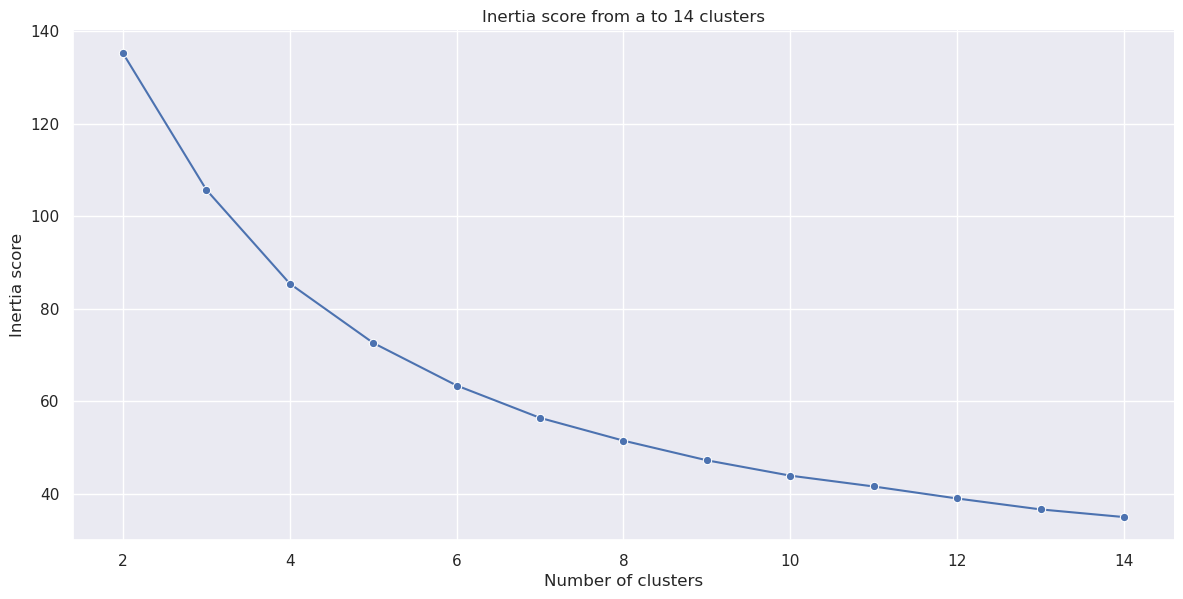

In [139]:
sns.set_theme(style='darkgrid')
(sns.relplot(kind='line',x=range(2,max_clusters+1),y=inertia_list,marker='o',height=6,aspect=2)
    .set(title=f"Inertia score from a to {max_clusters} clusters")
    .set_axis_labels("Number of clusters", "Inertia score")
);

### Silhouette scores

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

In [140]:
silhouette_list = []

for i in range(2,max_clusters+1):
    model_loop = KMeans(n_clusters=i,n_init=10,random_state=123)
    model_loop.fit(songs_col_df)
    score = silhouette_score(songs_col_df,model_loop.labels_)
    silhouette_list.append(round(score,2))
print(silhouette_list)

[0.42, 0.33, 0.32, 0.32, 0.31, 0.31, 0.3, 0.3, 0.3, 0.29, 0.29, 0.3, 0.27]


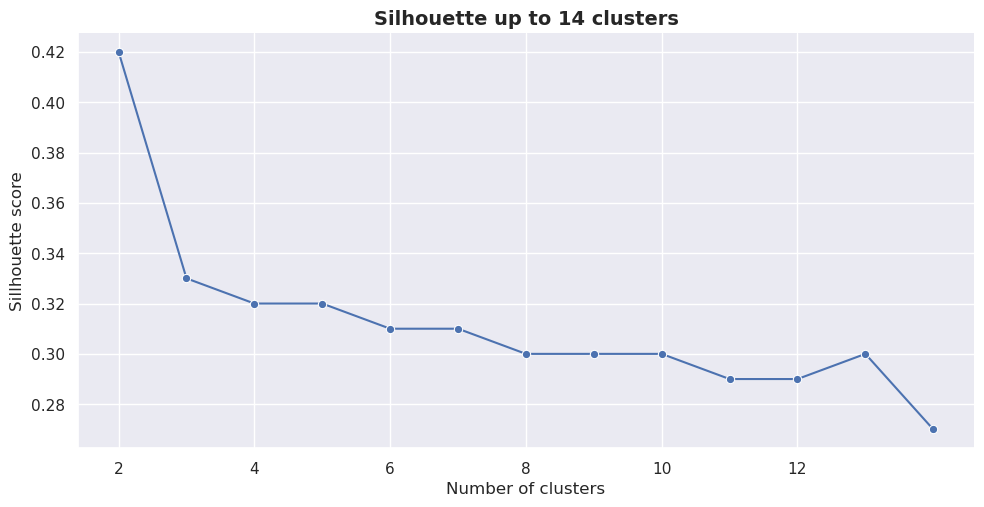

In [141]:
(sns.relplot(kind='line',x=range(2,max_clusters+1),y=silhouette_list,marker='o',height=5,aspect=2)
    .set(title=f"Silhouette up to {max_clusters} clusters")
    .set_axis_labels("Number of clusters", "Sillhouette score")
);
plt.xticks(range(2,max_clusters,2))
plt.title(f"Silhouette up to {max_clusters} clusters",fontweight="bold", fontsize=14)
plt.show()

* For k = 3 the average to silhouette is: 0.3349
	- For cluster = 0 the silhouette value is: 0.36
	- For cluster = 1 the silhouette value is: 0.39
	- For cluster = 2 the silhouette value is: 0.22
* For k = 4 the average to silhouette is: 0.3158
	- For cluster = 0 the silhouette value is: 0.19
	- For cluster = 1 the silhouette value is: 0.25
	- For cluster = 2 the silhouette value is: 0.43
	- For cluster = 3 the silhouette value is: 0.38
* For k = 5 the average to silhouette is: 0.3195
	- For cluster = 0 the silhouette value is: 0.22
	- For cluster = 1 the silhouette value is: 0.38
	- For cluster = 2 the silhouette value is: 0.24
	- For cluster = 3 the silhouette value is: 0.47
	- For cluster = 4 the silhouette value is: 0.28
* For k = 6 the average to silhouette is: 0.3132
	- For cluster = 0 the silhouette value is: 0.34
	- For cluster = 1 the silhouette value is: 0.28
	- For cluster = 2 the silhouette value is: 0.25
	- For cluster = 3 the silhouette value is: 0.28
	- For cluster = 4 t

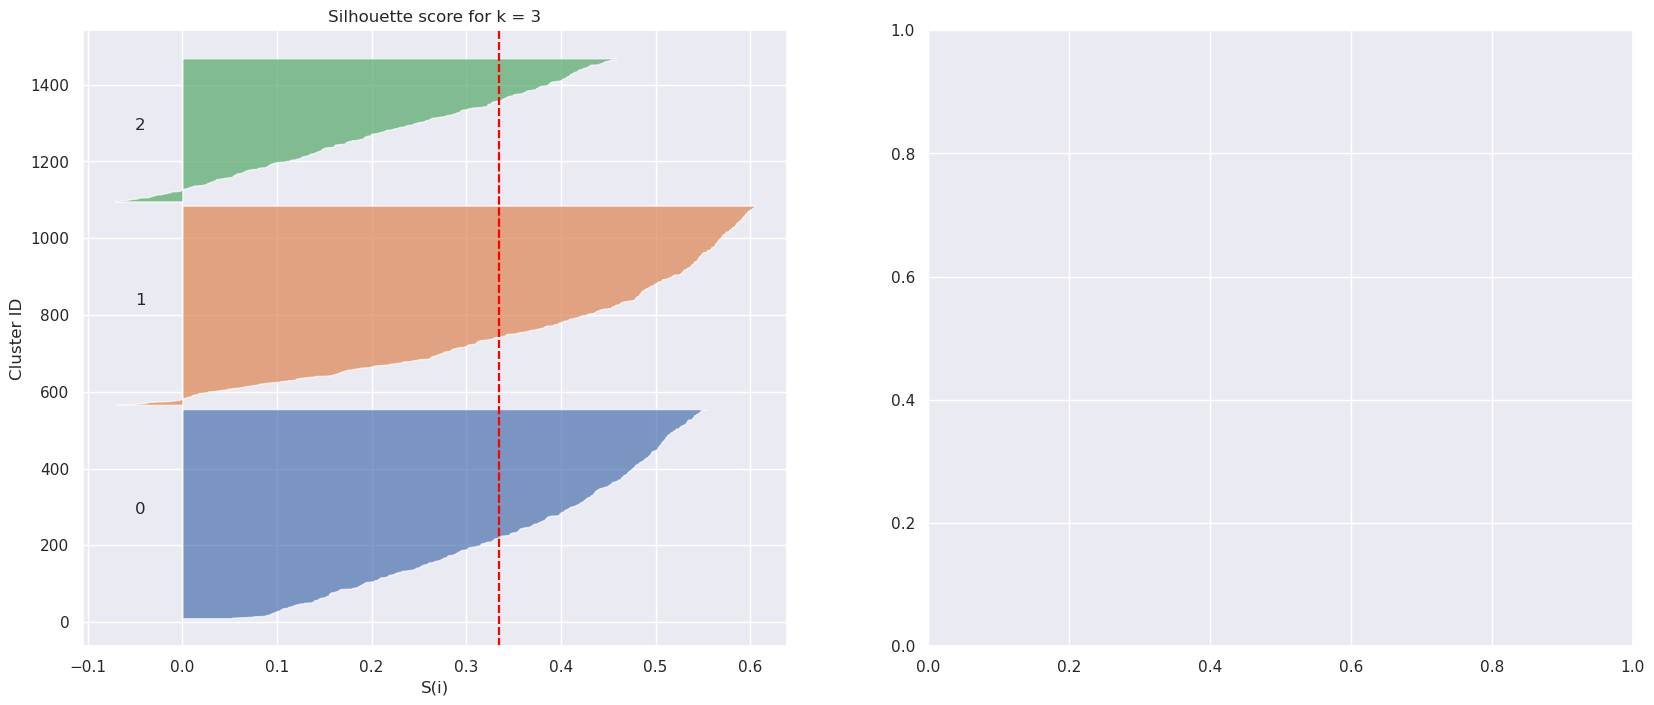

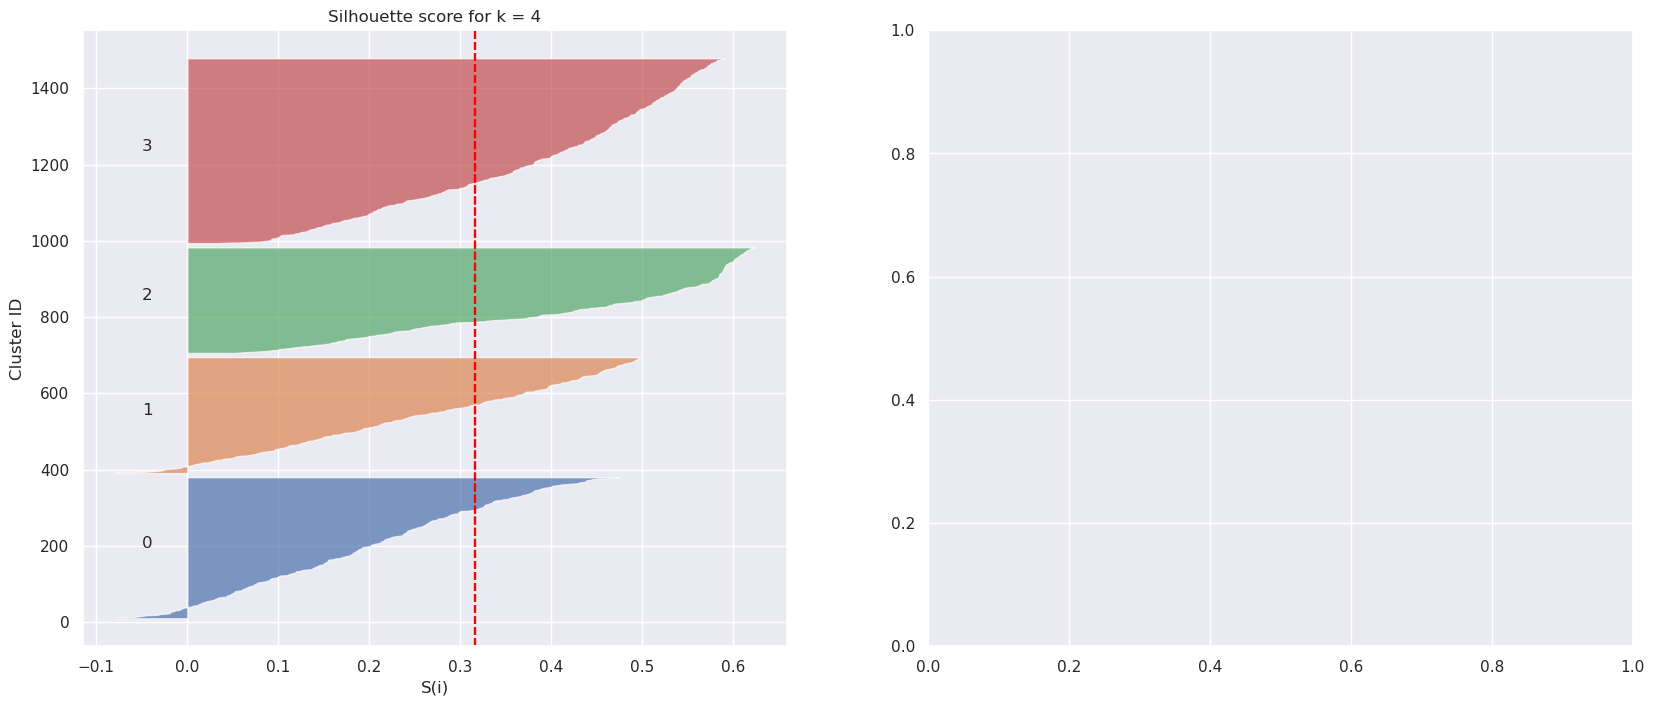

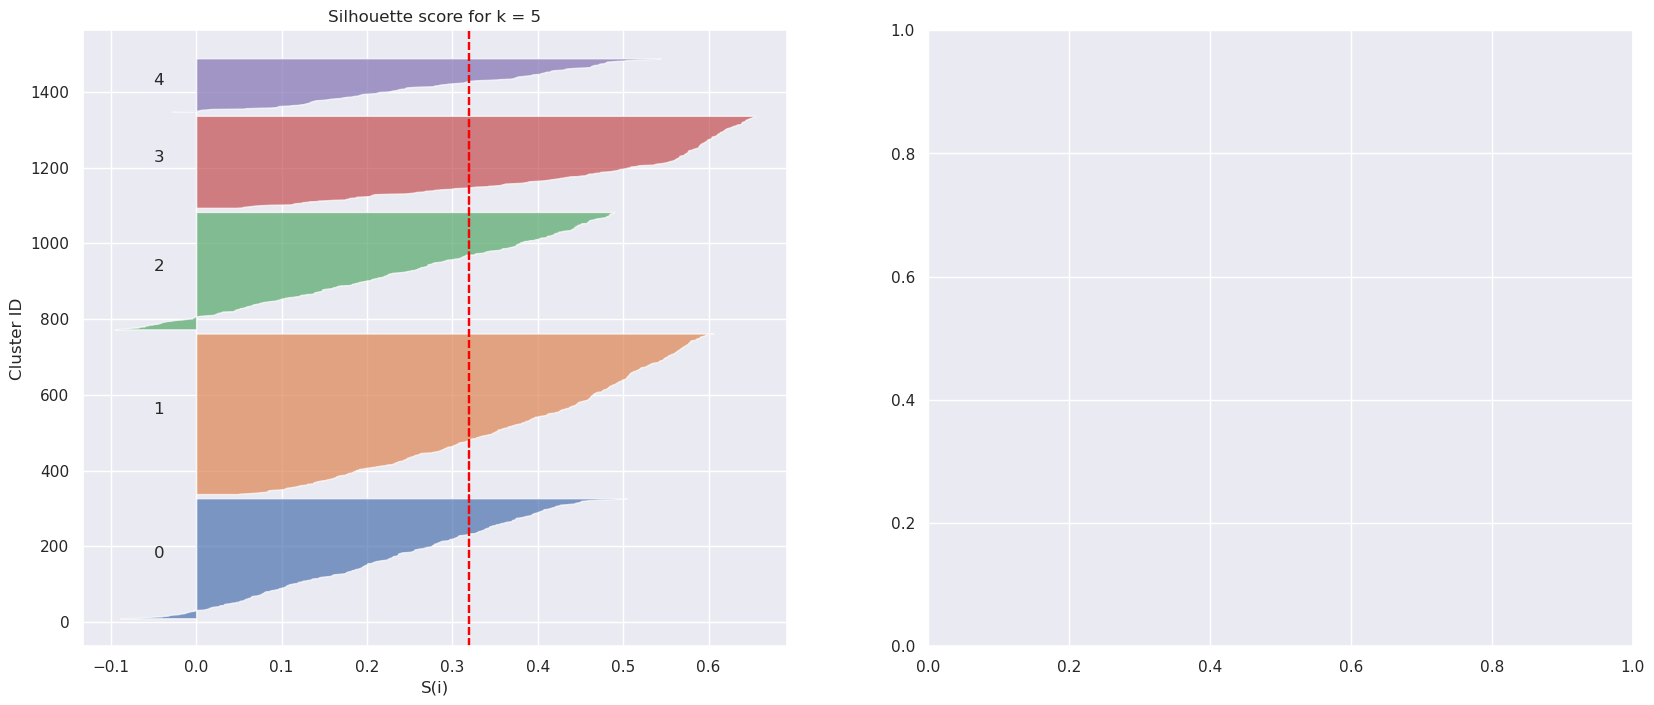

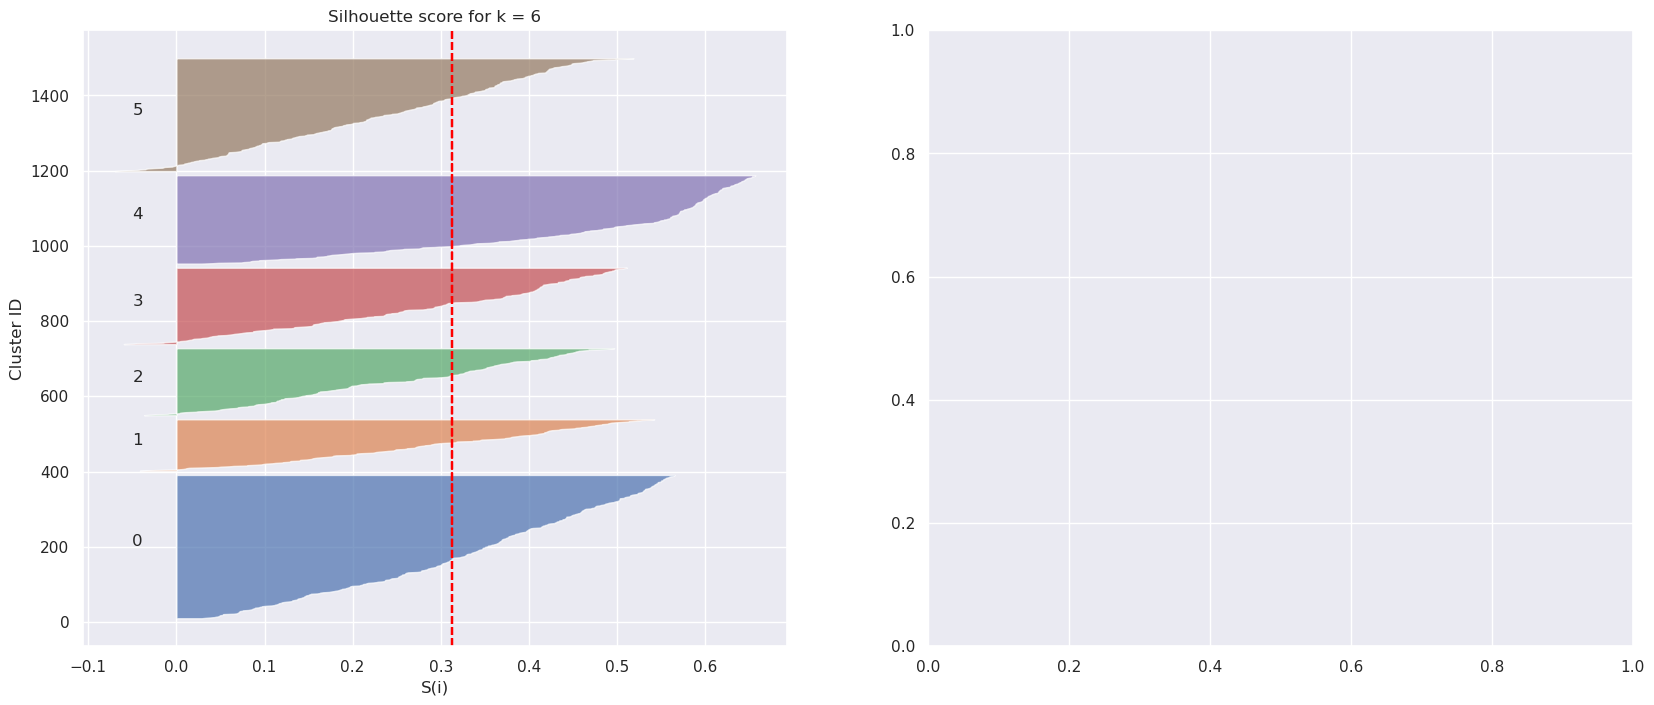

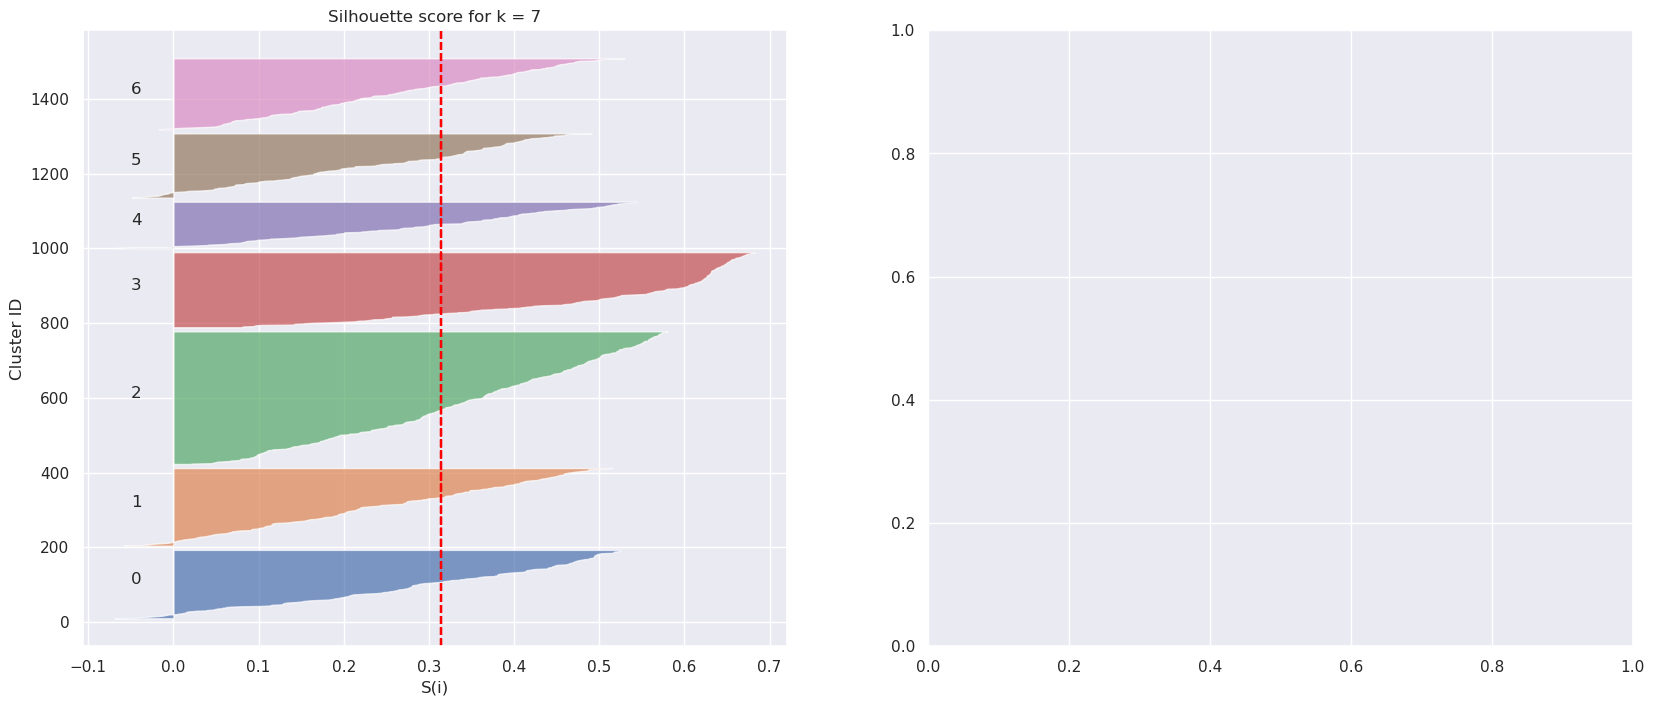

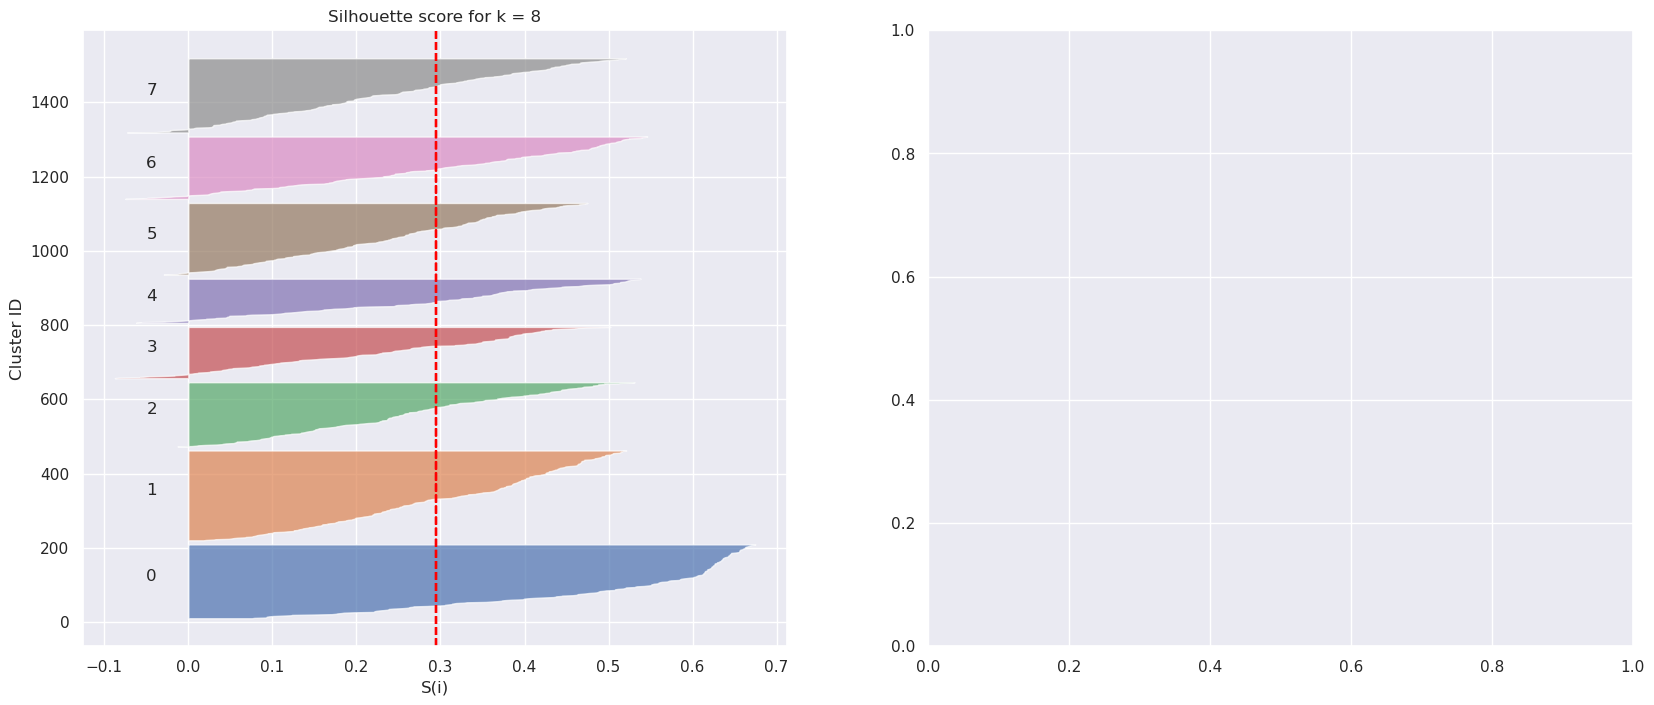

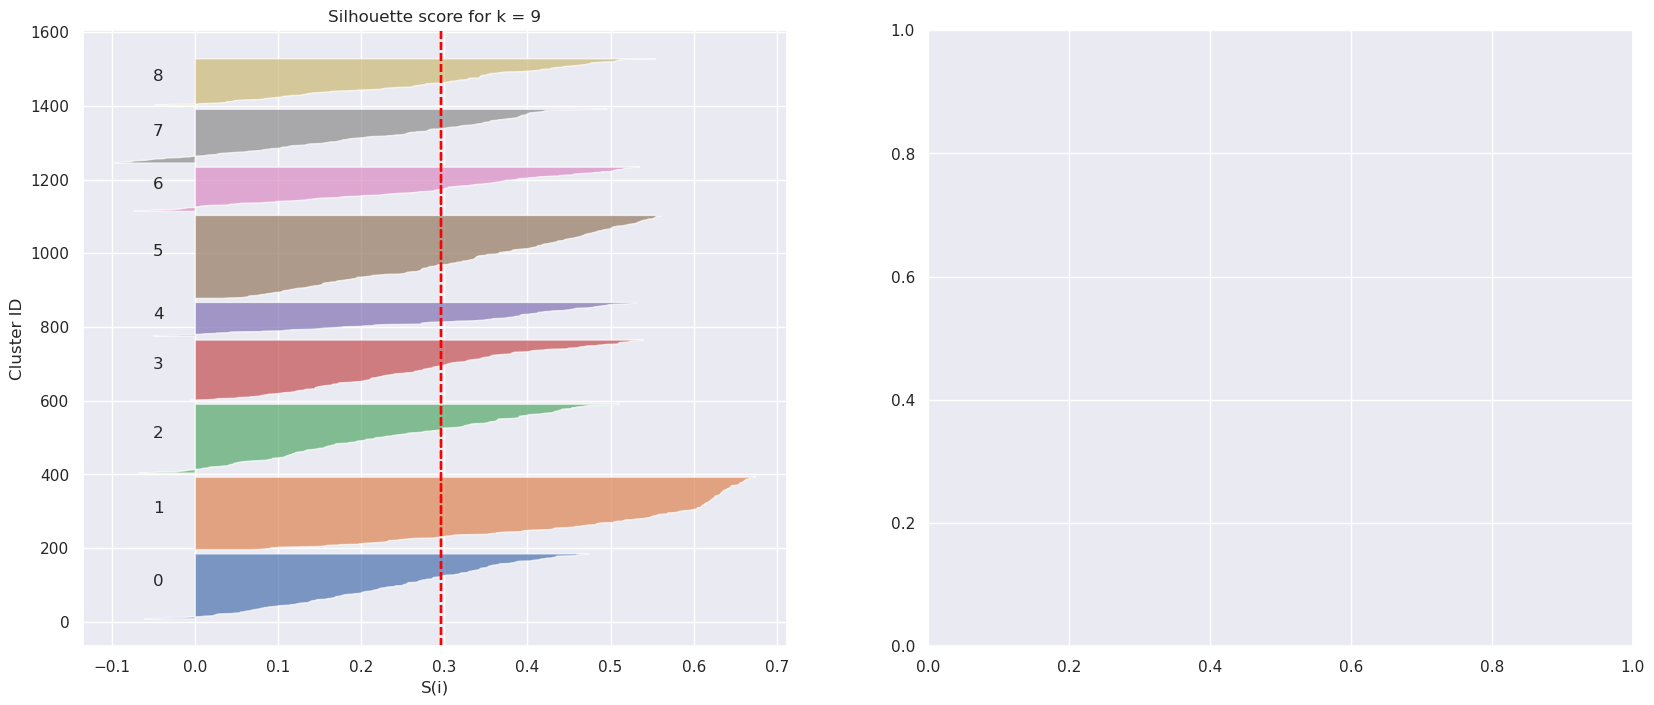

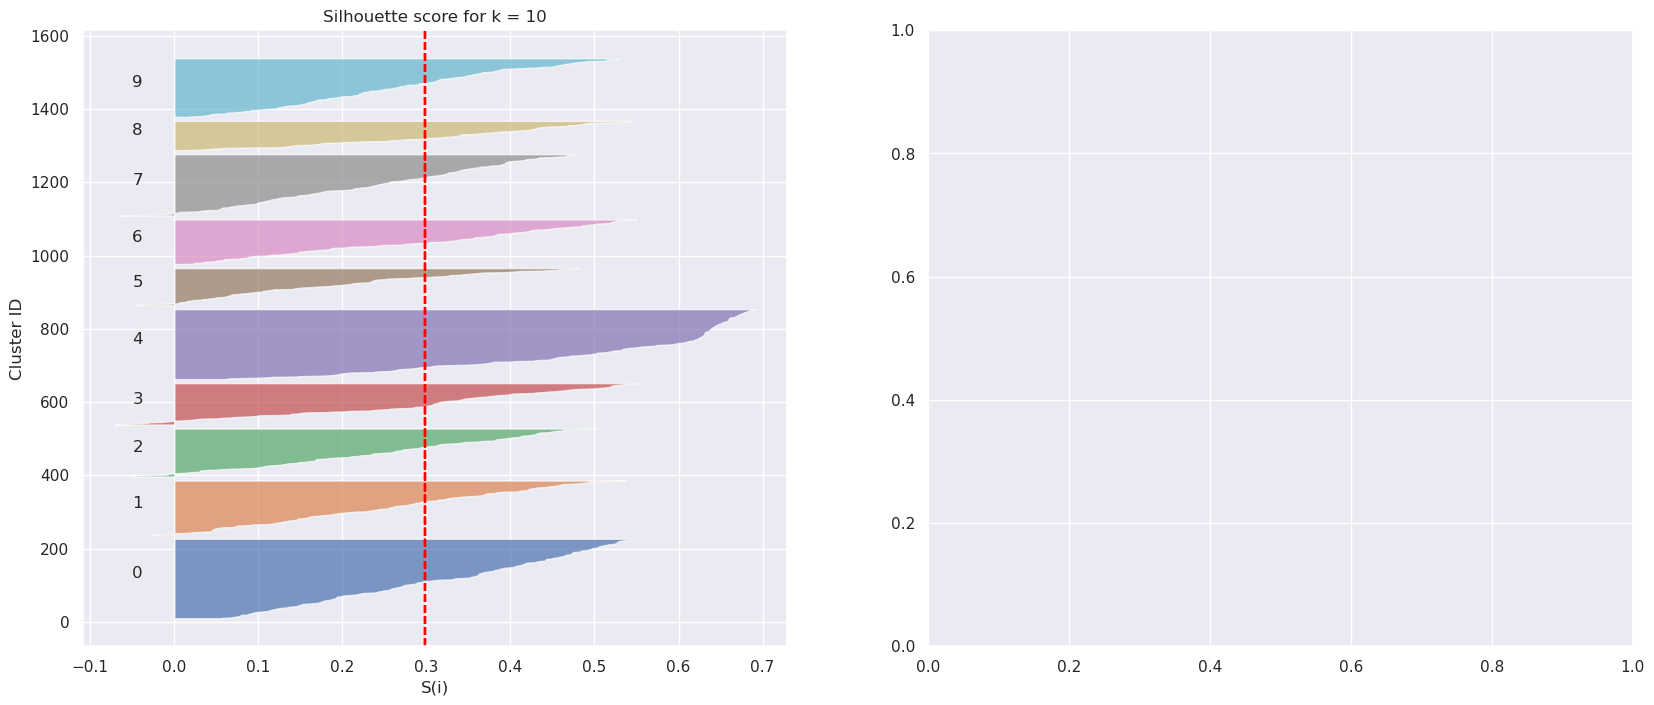

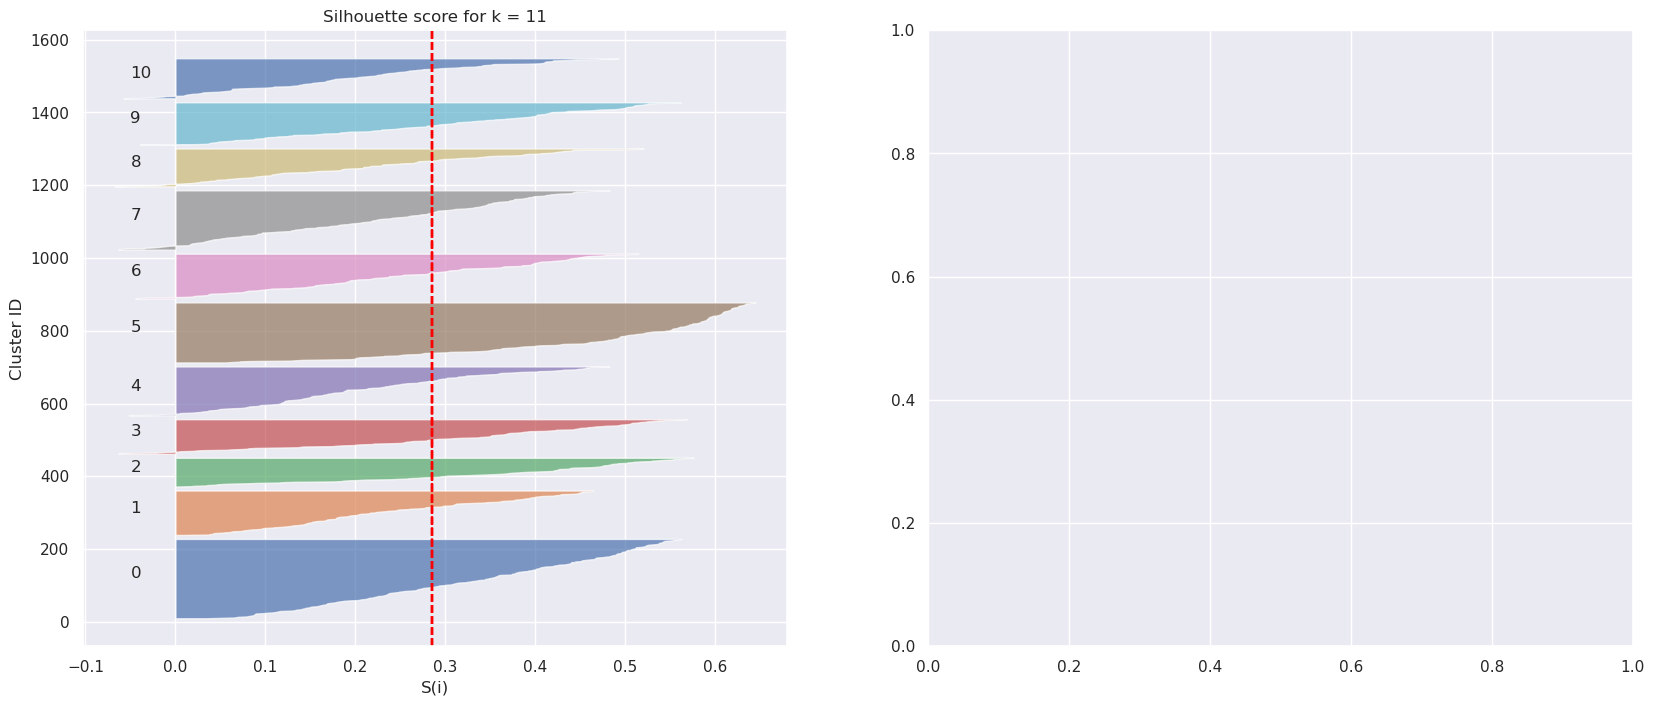

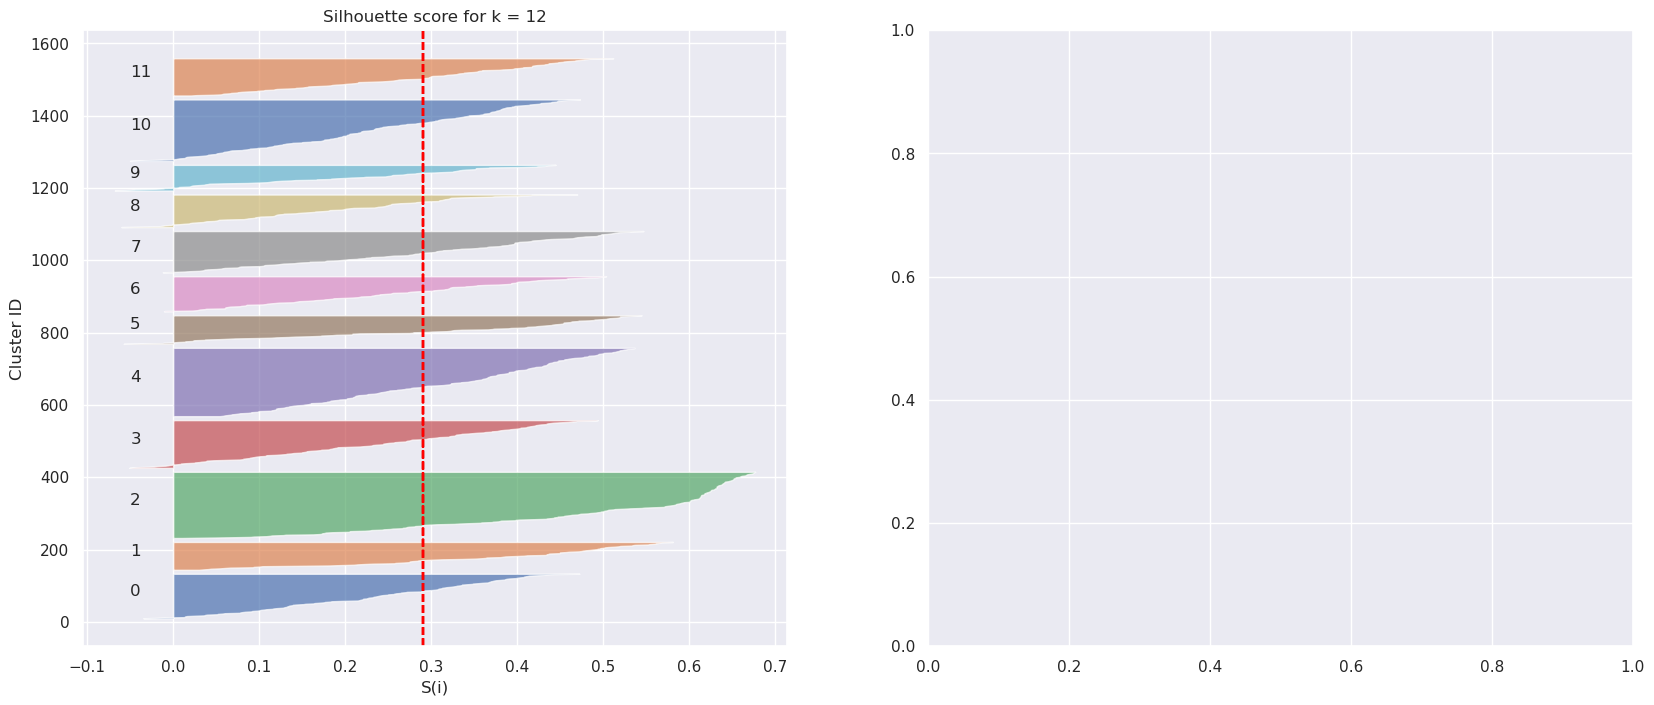

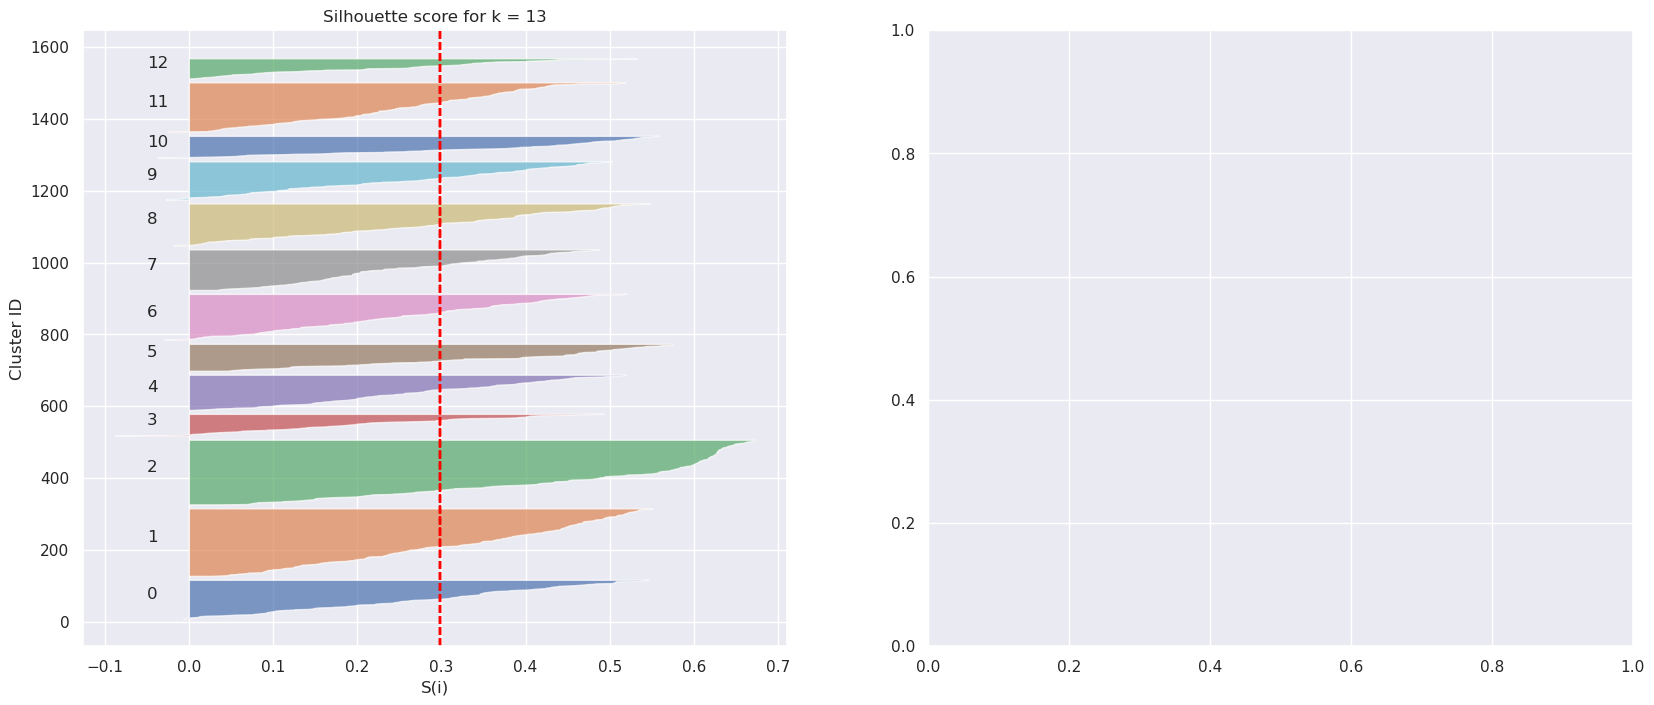

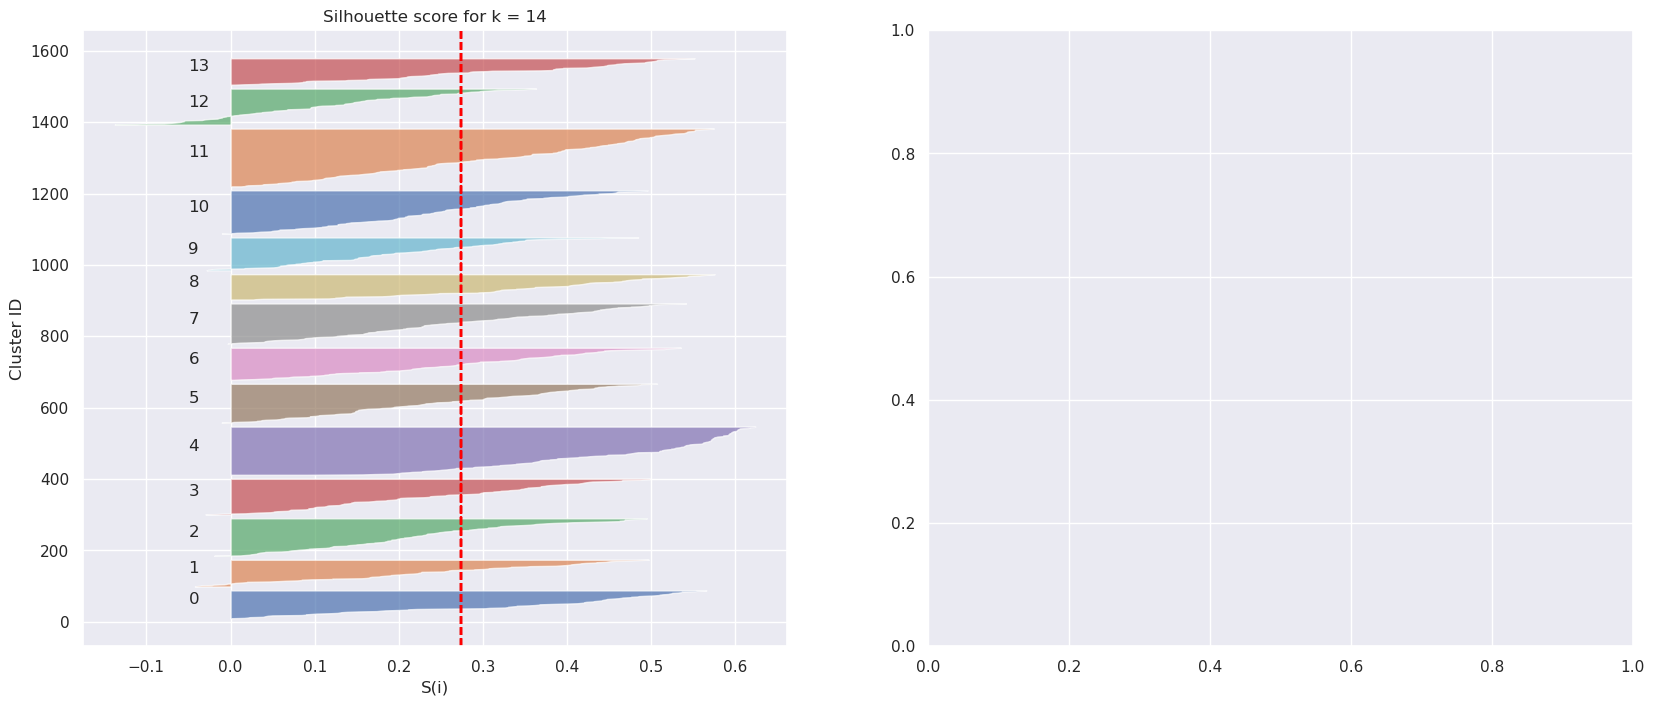

In [142]:
# Knife plot of clusters


data = songs_col_df

for k in range(3, max_clusters+1): 
    kmean_model = KMeans(n_clusters=k,n_init=10,random_state=123).fit(data)
    labels = kmean_model.labels_
    
    if 1 < k < data.shape[0]: 
        
        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.set_size_inches(20, 8)
        
        sil_avg = silhouette_score(data, labels)
        print(f"* For k = {k} the average to silhouette is: {round(sil_avg,4)}")
        sample_sil_val = silhouette_samples(data, labels)
        
        y_lower = 10
        
        for i in range(k): 
            ith_cluster_sv = sample_sil_val[labels == i]
            print(f"\t- For cluster = {i} the silhouette value is: {round(np.mean(ith_cluster_sv),2)}")
            
            ith_cluster_sv.sort()
            
            # Calculate where to put the silhuette on the y axes
            ith_cluster_size = ith_cluster_sv.shape[0]
            y_upper = y_lower + ith_cluster_size
 
            silhouette_avg = silhouette_score(songs_col_df, labels)
            axis1.axvline(x=silhouette_avg, color="red", linestyle="--")
            # Paint the cluster
            axis1.fill_betweenx(np.arange(y_lower, y_upper),
                               0, ith_cluster_sv, 
                                alpha = 0.7)
            
            
            # Label the cluster
            axis1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))
            
            # Calculate the next y lower value for the next cluster of the graph
            y_lower = y_upper + 10 # we left 10 spaces without any observation
            
        axis1.set_title("Silhouette score for k = %s"%str(k))
        axis1.set_xlabel("S(i)")
        axis1.set_ylabel("Cluster ID")
plt.show()

# 3. KMeans cluster model 

In [159]:
## Set cluster number in first and second line 
while True:
    try:
        cluster_no = int(input("Please choose the number of clusters (int): "))
        break
    except ValueError:
        print("Invalid input. Please try again.")


cluster_model = KMeans(n_clusters=cluster_no, n_init=10)
cluster_model.fit(songs_col_df)
cluster_model.cluster_centers_

Please choose the number of clusters (int):  5


array([[0.76013737, 0.69371452, 0.33520482],
       [0.19209789, 0.13909011, 0.2068188 ],
       [0.54085848, 0.78384482, 0.63283711],
       [0.28352284, 0.22165011, 0.638525  ],
       [0.5780628 , 0.34577043, 0.38093845]])

In [144]:
#Calculating the centroid position
cl_pos = pd.DataFrame(cluster_model.cluster_centers_)
cl_pos.columns = songs_col_df.columns

# Renaming the columns for merging with songs_plot_df below
cl_pos['cl_danceability']= cl_pos['danceability']
cl_pos['cl_energy']= cl_pos['energy']
cl_pos['cl_tempo']= cl_pos['tempo']
cl_pos = cl_pos.drop(['danceability','energy','tempo'],axis=1)


In [145]:
# Labeling the clusters
cluster_model.labels_
songs_plot_df = songs_col_df.copy()
songs_plot_df['cluster'] = cluster_model.labels_
songs_plot_df.head(5)

,danceability,energy,tempo,cluster
0,0.624060,0.469869,0.156106,2
1,0.580938,0.247977,0.494567,1
2,0.254755,0.227896,0.412383,1
3,0.531181,0.683728,0.247063,2
4,0.437196,0.167654,0.168742,1


In [146]:
# Selecting songs closest to the cluster centroid

In [147]:
# Merging the data frames with song audio features and cluster centroid positions to calculate the distances
songs_distance_df = pd.merge(songs_plot_df,cl_pos, how='left', left_on='cluster', right_index=True)

# Calculating Euclydian distances to identify songs closest to the cluster centroids
distances_dict = {}
clusters_df = songs_distance_df.copy()
clusters_df["eucl_dist"] = ""
distances = []

for i in range(len(clusters_df)):
    distance = ((clusters_df.iloc[i,0]-clusters_df.iloc[i,4])**2+(clusters_df.iloc[i,1]-clusters_df.iloc[i,5])**2+(clusters_df.iloc[i,2]-clusters_df.iloc[i,6])**2)**0.5
    clusters_df.at[i,'eucl_dist'] = distance

clusters_df['eucl_dist'] = clusters_df['eucl_dist'].apply(pd.to_numeric)
clusters_df

,danceability,energy,tempo,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist
0,0.624060,0.469869,0.156106,2,0.737227,0.635058,0.342509,0.273570
1,0.580938,0.247977,0.494567,1,0.312635,0.184600,0.342101,0.315037
2,0.254755,0.227896,0.412383,1,0.312635,0.184600,0.342101,0.100818
3,0.531181,0.683728,0.247063,2,0.737227,0.635058,0.342509,0.232236
4,0.437196,0.167654,0.168742,1,0.312635,0.184600,0.342101,0.214140
...,...,...,...,...,...,...,...,...
1435,0.157452,0.069660,0.244005,1,0.312635,0.184600,0.342101,0.216601
1436,0.141973,0.101387,0.213537,1,0.312635,0.184600,0.342101,0.229301
1437,0.000000,0.000913,0.139723,1,0.312635,0.184600,0.342101,0.415257
1438,0.081159,0.020864,0.111222,1,0.312635,0.184600,0.342101,0.365645


In [148]:
clusters_df

,danceability,energy,tempo,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist
0,0.624060,0.469869,0.156106,2,0.737227,0.635058,0.342509,0.273570
1,0.580938,0.247977,0.494567,1,0.312635,0.184600,0.342101,0.315037
2,0.254755,0.227896,0.412383,1,0.312635,0.184600,0.342101,0.100818
3,0.531181,0.683728,0.247063,2,0.737227,0.635058,0.342509,0.232236
4,0.437196,0.167654,0.168742,1,0.312635,0.184600,0.342101,0.214140
...,...,...,...,...,...,...,...,...
1435,0.157452,0.069660,0.244005,1,0.312635,0.184600,0.342101,0.216601
1436,0.141973,0.101387,0.213537,1,0.312635,0.184600,0.342101,0.229301
1437,0.000000,0.000913,0.139723,1,0.312635,0.184600,0.342101,0.415257
1438,0.081159,0.020864,0.111222,1,0.312635,0.184600,0.342101,0.365645


In [149]:
int((round(len(songs_df)*(0.5*(1/cluster_no))),0)[0])

240

In [150]:
cluster_size = int((round(len(songs_df)*(0.5*(1/cluster_no))),0)[0])
clusters_df.loc[clusters_df['cluster']==0].nsmallest(int(cluster_size),'eucl_dist')

,danceability,energy,tempo,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist
432,0.578726,0.734934,0.614867,0,0.529626,0.726781,0.63598,0.054065
249,0.582043,0.702805,0.622868,0,0.529626,0.726781,0.63598,0.059113
342,0.547766,0.664652,0.628505,0,0.529626,0.726781,0.63598,0.065154
17,0.559929,0.713850,0.701936,0,0.529626,0.726781,0.63598,0.073728
437,0.540027,0.652603,0.608132,0,0.529626,0.726781,0.63598,0.079913
...,...,...,...,...,...,...,...,...
594,0.805396,0.801201,0.596090,0,0.529626,0.726781,0.63598,0.288407
975,0.653914,0.935742,0.793742,0,0.529626,0.726781,0.63598,0.289829
868,0.578726,0.462840,0.524754,0,0.529626,0.726781,0.63598,0.290597
664,0.622954,0.986948,0.544527,0,0.529626,0.726781,0.63598,0.291136


In [151]:
cluster_size = int((round(len(songs_df)*(0.5*(1/cluster_no))),0)[0])
top_cluster = pd.DataFrame()#appended_cluster = []
for i in range(cluster_no+1):
    cluster = clusters_df.loc[clusters_df['cluster']==i].nsmallest(int(cluster_size),'eucl_dist')
    final_cluster=pd.concat([top_cluster,cluster], axis=1)
final_cluster

,danceability,energy,tempo,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist


In [152]:
cluster_size = int((round(len(songs_df)*(0.5*(1/cluster_no))),0)[0])
appended_cluster = []
for i in range(cluster_no+1):
    cluster = clusters_df.loc[clusters_df['cluster']==i].nsmallest(int(cluster_size),'eucl_dist')
    appended_cluster.append(cluster)  
appended_cluster = pd.concat(appended_cluster)
appended_cluster

,danceability,energy,tempo,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist
432,0.578726,0.734934,0.614867,0,0.529626,0.726781,0.635980,0.054065
249,0.582043,0.702805,0.622868,0,0.529626,0.726781,0.635980,0.059113
342,0.547766,0.664652,0.628505,0,0.529626,0.726781,0.635980,0.065154
17,0.559929,0.713850,0.701936,0,0.529626,0.726781,0.635980,0.073728
437,0.540027,0.652603,0.608132,0,0.529626,0.726781,0.635980,0.079913
...,...,...,...,...,...,...,...,...
1173,0.880584,0.620474,0.206252,2,0.737227,0.635058,0.342509,0.198318
251,0.625166,0.761039,0.447122,2,0.737227,0.635058,0.342509,0.198426
230,0.580938,0.513042,0.358879,2,0.737227,0.635058,0.342509,0.198953
1061,0.638434,0.614450,0.169872,2,0.737227,0.635058,0.342509,0.199971


In [153]:


clusters_0 = clusters_df.loc[clusters_df['cluster']==0].nsmallest(15,'eucl_dist') 
clusters_1 = clusters_df.loc[clusters_df['cluster']==1].nsmallest(15,'eucl_dist')
clusters_2 = clusters_df.loc[clusters_df['cluster']==2].nsmallest(50,'eucl_dist')
clusters_3 = clusters_df.loc[clusters_df['cluster']==3].nsmallest(50,'eucl_dist')
clusters_4 = clusters_df.loc[clusters_df['cluster']==4].nsmallest(50,'eucl_dist')
clusters_5 = clusters_df.loc[clusters_df['cluster']==5].nsmallest(50,'eucl_dist')

top50_clusters = pd.concat([clusters_0, clusters_1, clusters_2, clusters_3, clusters_4, clusters_5], axis=0)
top50_clusters_plot = top50_clusters.copy()


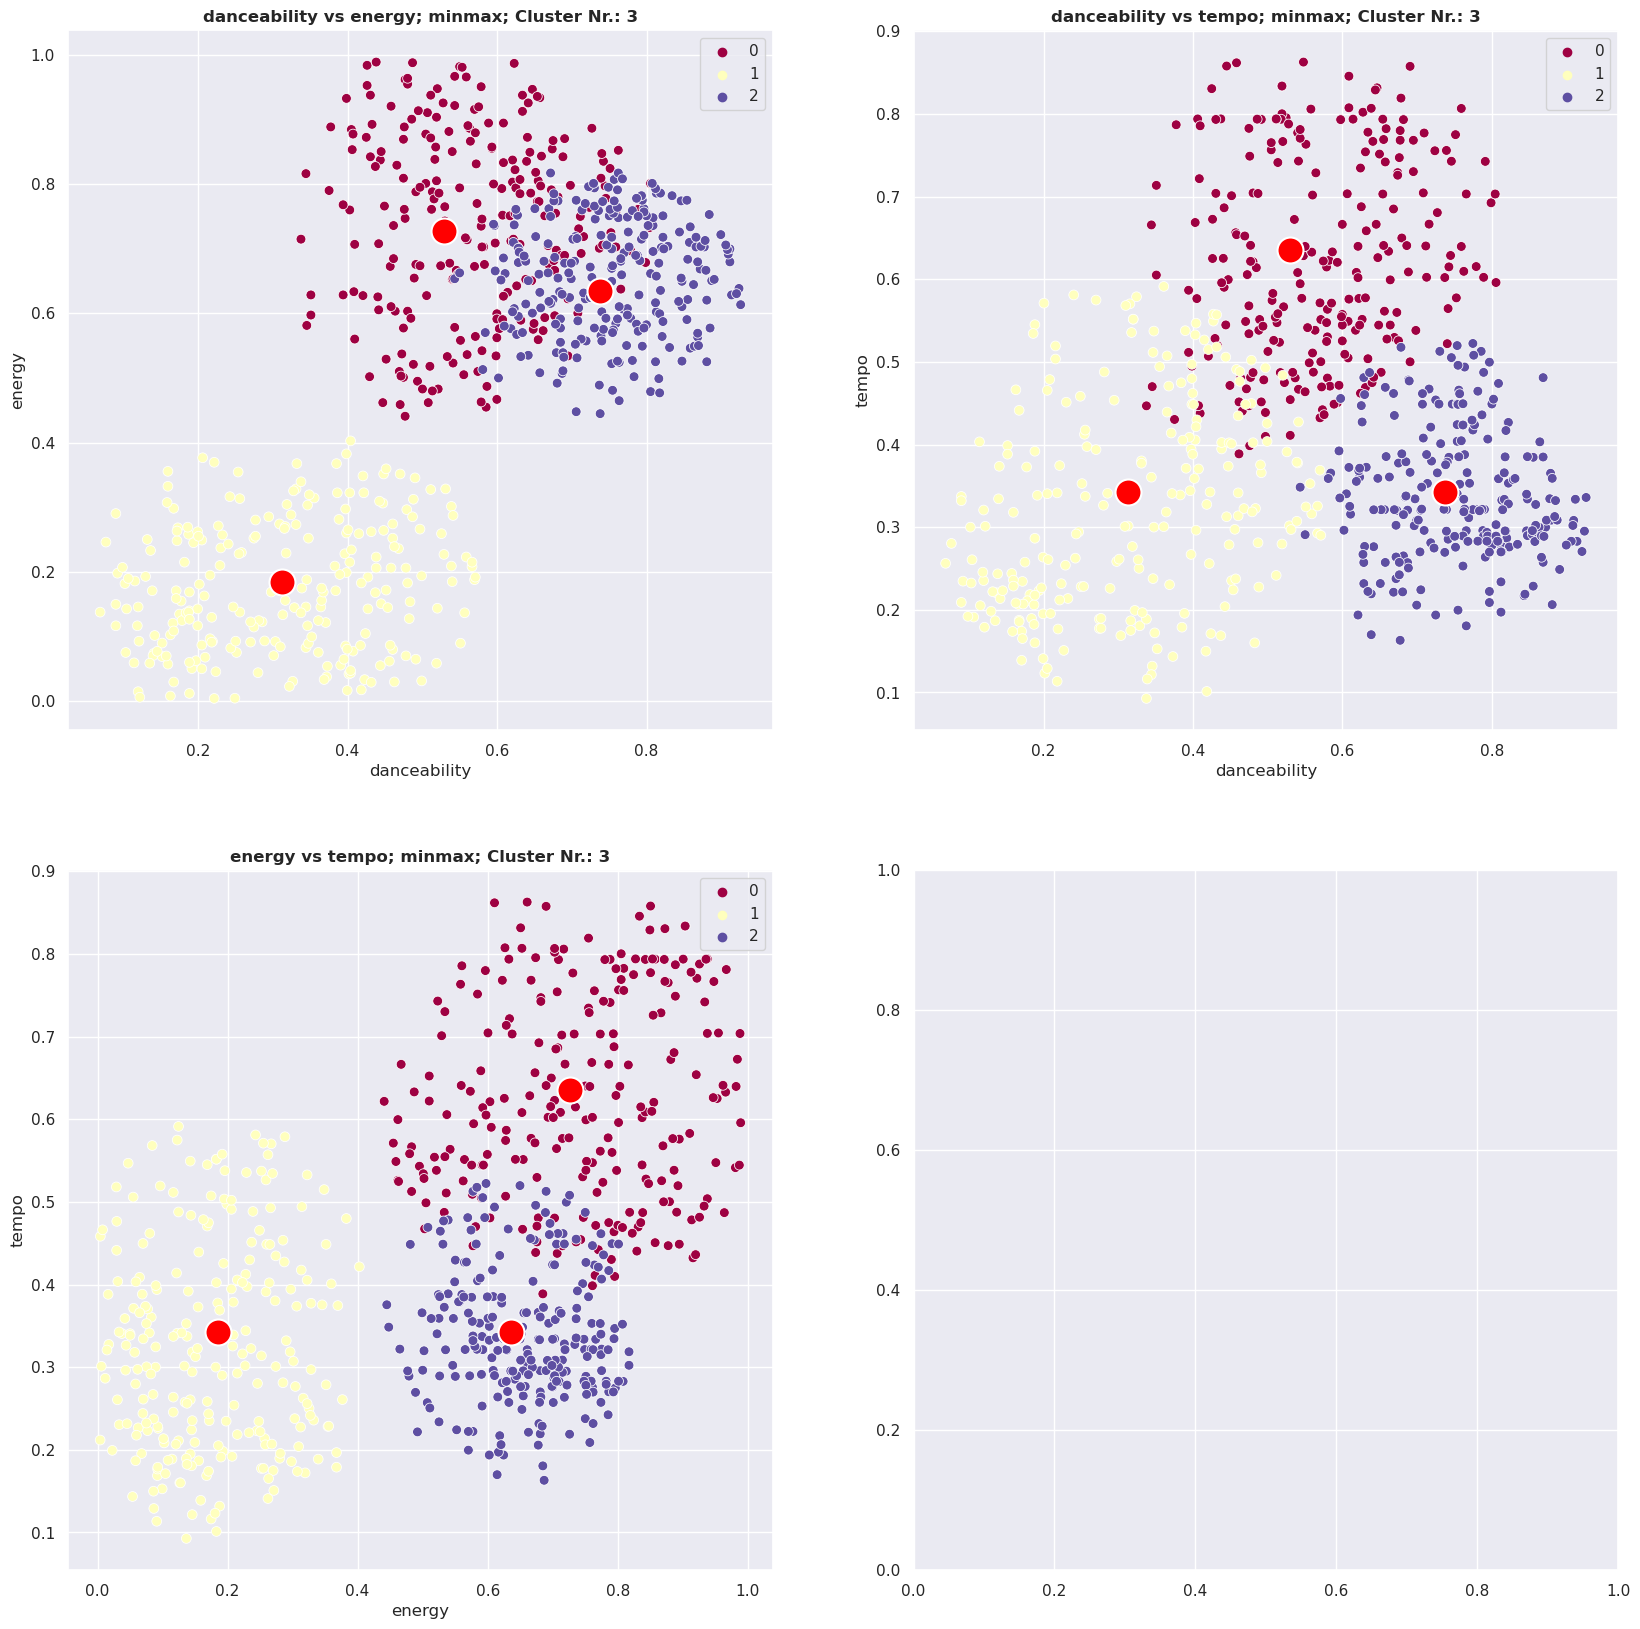

In [154]:
# scatter plots
## MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer

## min_max_df, standard_df, robust_df, quantile_df, power_df
data_plot=appended_cluster#songs_plot_df
## cl_pos_m, cl_pos_s, cl_pos_r, cl_pos_q, cl_pos_m
data_centroids = cl_pos
## picking the column, which has 'cluster' in the name
cluster = [col for col in data_plot if col.startswith('cluster')][0]
## -------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------

## PLOT
fig, ax = plt.subplots(2,2, figsize=(20, 20))

## GRAPHS
sns.scatterplot(data=data_plot, x='danceability', y='energy', s=50, hue= cluster, palette='Spectral', ax=ax[0, 0])
sns.scatterplot(data=data_plot, x='danceability', y='tempo', s=50, hue= cluster, palette='Spectral', ax=ax[0, 1])
sns.scatterplot(data=data_plot, x='energy', y='tempo', s=50, hue= cluster, palette='Spectral', ax=ax[1, 0])

## CENTROIDS
sns.scatterplot(data=data_centroids, x='cl_danceability', y='cl_energy', color='red', s=350, ax=ax[0, 0])
sns.scatterplot(data=data_centroids, x='cl_danceability', y='cl_tempo', color='red', s=350, ax=ax[0, 1])
sns.scatterplot(data=data_centroids, x='cl_energy', y='cl_tempo', color='red', s=350, ax=ax[1, 0])

## LABEL
ax[0, 0].set_title(f'danceability vs energy; {scale_name}; Cluster Nr.: {str(cluster_no)}', fontweight="bold")
ax[0, 1].set_title(f'danceability vs tempo; {scale_name}; Cluster Nr.: {str(cluster_no)}', fontweight="bold")
ax[1, 0].set_title(f'energy vs tempo; {scale_name}; Cluster Nr.: {str(cluster_no)}', fontweight="bold")

plt.show()

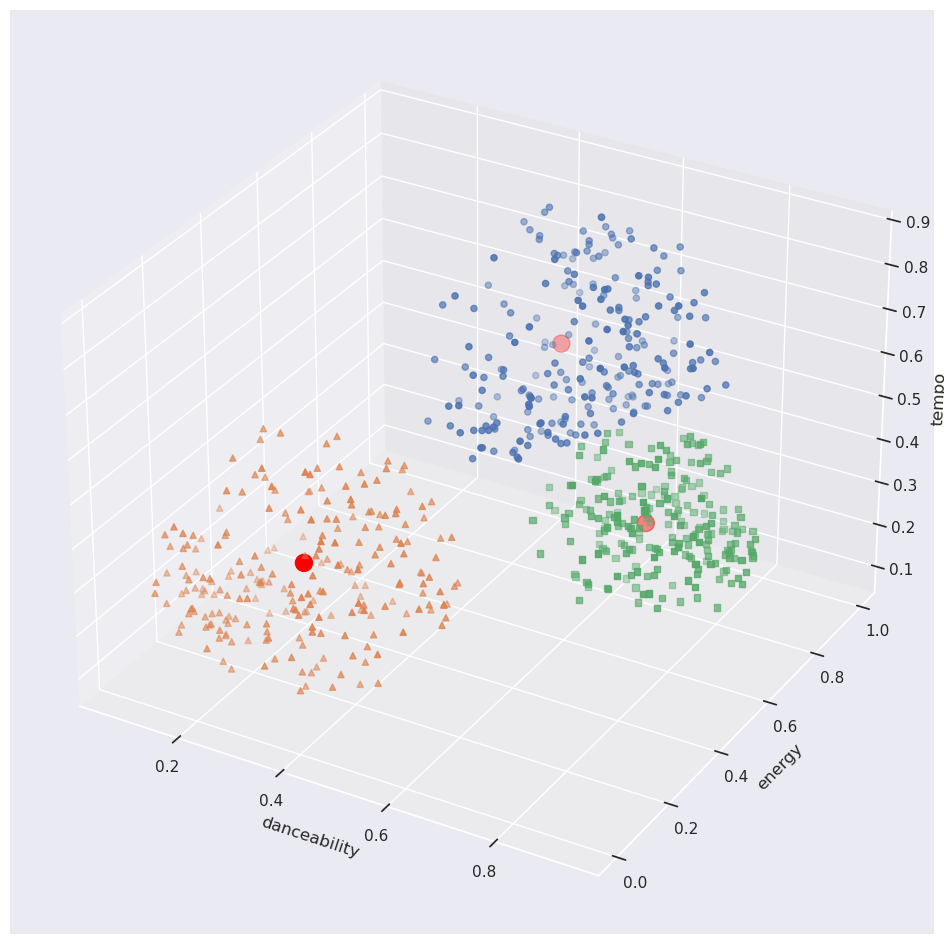

In [155]:
# 3D plot
appended_cluster_plot = appended_cluster[['danceability','energy','tempo','cluster']]

plot_data = appended_cluster

colors = ['r','g','b']
markers = ['o', '^','s','x','v','o']
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# ax.scatter(plot_data['bill_depth_mm'], plot_data['bill_length_mm'], plot_data['flipper_length_mm'])
for marker, d in plot_data.groupby('cluster'):
    ax.scatter(d['danceability'], d['energy'], d['tempo'], marker=markers[marker], label=d['cluster'])
ax.scatter(cl_pos['cl_danceability'], cl_pos['cl_energy'],cl_pos['cl_tempo'], color='red', s=150)
ax.set_xlabel('danceability')
ax.set_ylabel('energy')
ax.set_zlabel('tempo')
plt.show()

In [158]:
clusters_final_df = pd.merge(songs_full_df,top50_clusters, left_index=True, right_index=True)
clusters_final_df

,name,artist,danceability_x,energy_x,key,loudness,mode,speechiness,acousticness,instrumentalness,...,id,html,danceability_y,energy_y,tempo_y,cluster,cl_danceability,cl_energy,cl_tempo,eucl_dist
2,Smoke Gets In Your Eyes,The Platters,0.290,0.2270,3,-13.060,1,0.0311,0.9440,0.000079,...,307XEC1IUwUs9ojlEFwH7f,https://open.spotify.com/track/307XEC1IUwUs9oj...,0.254755,0.227896,0.412383,1,0.312635,0.184600,0.342101,0.100818
15,Wake up Little Susie,The Everly Brothers,0.709,0.6200,2,-9.382,1,0.0340,0.3180,0.000000,...,11fNLqDB47gMKj7BHhR2Qr,https://open.spotify.com/track/11fNLqDB47gMKj7...,0.718045,0.622482,0.281145,2,0.737227,0.635058,0.342509,0.065511
17,Rave On,Buddy Holly,0.566,0.7110,0,-6.536,1,0.0335,0.6110,0.000007,...,33aYzW5ToRjiFOzkubeJ8H,https://open.spotify.com/track/33aYzW5ToRjiFOz...,0.559929,0.713850,0.701936,0,0.529626,0.726781,0.635980,0.073728
75,I'm Walkin',Fats Domino,0.729,0.5550,1,-13.056,1,0.0483,0.6780,0.184000,...,07TQDFaoLBwvo6JU1nnaiU,https://open.spotify.com/track/07TQDFaoLBwvo6J...,0.740159,0.557220,0.378716,2,0.737227,0.635058,0.342509,0.085898
109,Mr. Blue,The Fleetwoods,0.374,0.0889,4,-17.475,1,0.0356,0.9310,0.000007,...,6bnFjTW3EnMG4BwreDnSHK,https://open.spotify.com/track/6bnFjTW3EnMG4Bw...,0.347634,0.089238,0.300005,1,0.312635,0.184600,0.342101,0.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,Man On Fire,Idahams,0.772,0.6870,2,-7.398,0,0.1640,0.0445,0.000006,...,5iOKGigwmEPBSPSkM8v5lx,https://open.spotify.com/track/5iOKGigwmEPBSPS...,0.787705,0.689753,0.295900,2,0.737227,0.635058,0.342509,0.087817
1352,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",Ludwig van Beethoven,0.291,0.1370,9,-18.344,1,0.0389,0.9270,0.767000,...,3UkIZn9Brm9kwriMOkPShv,https://open.spotify.com/track/3UkIZn9Brm9kwri...,0.255860,0.137533,0.337273,1,0.312635,0.184600,0.342101,0.073906
1357,"Symphony No.1 in C minor, Op.68: 1. Un poco so...",Johannes Brahms,0.257,0.1290,0,-16.010,0,0.0351,0.9510,0.904000,...,6jWrXbhQcKEN7Zhzh84iTL,https://open.spotify.com/track/6jWrXbhQcKEN7Zh...,0.218266,0.129500,0.341519,1,0.312635,0.184600,0.342101,0.109279
1381,"Symphony No. 3 in G Minor, Op. 36: I. Adagio -...",Louise Farrenc,0.343,0.1330,7,-18.721,0,0.0340,0.9620,0.808000,...,3PM3acBhUaj2bIeHu3BxYY,https://open.spotify.com/track/3PM3acBhUaj2bIe...,0.313357,0.133516,0.301371,1,0.312635,0.184600,0.342101,0.065337
